In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
import os

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import numpy as np

from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.experiment import build_environment
from dynamic_programming.opinion_dynamics.common.viz import interpolate_opinion_trajectory, plot_action_heatmap, plot_opinions_over_time

def instantiate_agent(exp_subdir_path: str) -> AgentDQN:
    """
    Instantiate an AgentDQN using the configuration stored in a YAML file 
    in the provided experiment subdirectory. The agent is created with the 
    given training and validation environments and loads its previous state.
    
    Args:
        exp_subdir_path (str): Path to the experiment subdirectory containing the config YAML and checkpoint files.

    
    Returns:
        AgentDQN: An instance of AgentDQN initialized using the experiment configuration and saved state.
    """
    # Assume the YAML configuration is stored as 'config.yaml' in the experiment folder.
    config_path = os.path.join(exp_subdir_path, "cfg.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at {config_path}")
    
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Instantiate the agent.
    # The resume_training_path is set to the experiment folder so that the agent loads saved weights/stats.
    agent = AgentDQN(
        resume_training_path=exp_subdir_path,
        experiment_name=config["experiment"],
        config=config,
        save_checkpoints=False,  # you can set this as needed
        logger=setup_logger("dqn")
    )
    
    return agent

def run_policy_agent(agent, max_steps=1000):
    """
    Run the simulation using the agent’s policy (exploitation only).
    
    Args:
        env: The environment (which must have a reset and step method).
        agent: An already-trained AgentDQN instance.
        max_steps: Maximum number of steps to run.
        
    Returns:
        opinions_over_time: Array of opinions (states) over time.
        time_points: Array of time stamps.
        rewards_over_time: Array of rewards collected at each step.
        actions_over_time: Array of actions taken at each step.
    """
    time_points = []
    rewards_over_time = []
    actions_over_time = []  # New: record the actions used.
    opinions_over_time = []
    env = agent.validation_env
    
    current_time = 0.0
    # Reset environment
    state, _ = env.reset()
    opinions_over_time.append(state.copy())
    
    for step in range(max_steps):
        # Convert state to a batched tensor (batch size = 1)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        # Use the agent in exploitation mode (epsilon=0, random_action=False)
        # The agent.select_action returns (action, beta_idx, q_value)
        action, _, _, _ = agent.select_action(state_tensor, epsilon=0.0, random_action=False)
        # action is returned as a NumPy array with shape (1, n_agents)
        action = np.squeeze(action)  # Now action has shape (n_agents,)
        actions_over_time.append(action.copy())
        
        # Apply the action in the environment.
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        
        current_time += env.tau
        state = next_state
        
        if done or truncated:
            print(f"Simulation ended at step {step}: done={done}, truncated={truncated}")
            break

    return (np.array(opinions_over_time),
            np.array(time_points),
            np.array(rewards_over_time),
            np.array(actions_over_time))

2025-05-31 23:12:21,593 - dqn - INFO - opinion_dqn.py:266 - Loaded configuration settings.
2025-05-31 23:12:21,595 - dqn - INFO - opinion_dqn.py:328 - Initialized networks and optimizer.
2025-05-31 23:12:28,171 - dqn - INFO - opinion_dqn.py:211 - Loaded previous training status from the following files: {'replay_buffer_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May29-012929_configs\\0000_optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.5__agent_params.args_.target_model_update_freq_1000\\1\\opinion_agent_dqn_replay_buffer', 'train_stats_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May29-012929_configs\\0000_optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.5__agent_params.args_.target_model_update_freq_1000\\1\\opinion_agent_dqn_train_stats', 'checkpoint_model_file': 'D:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025May2

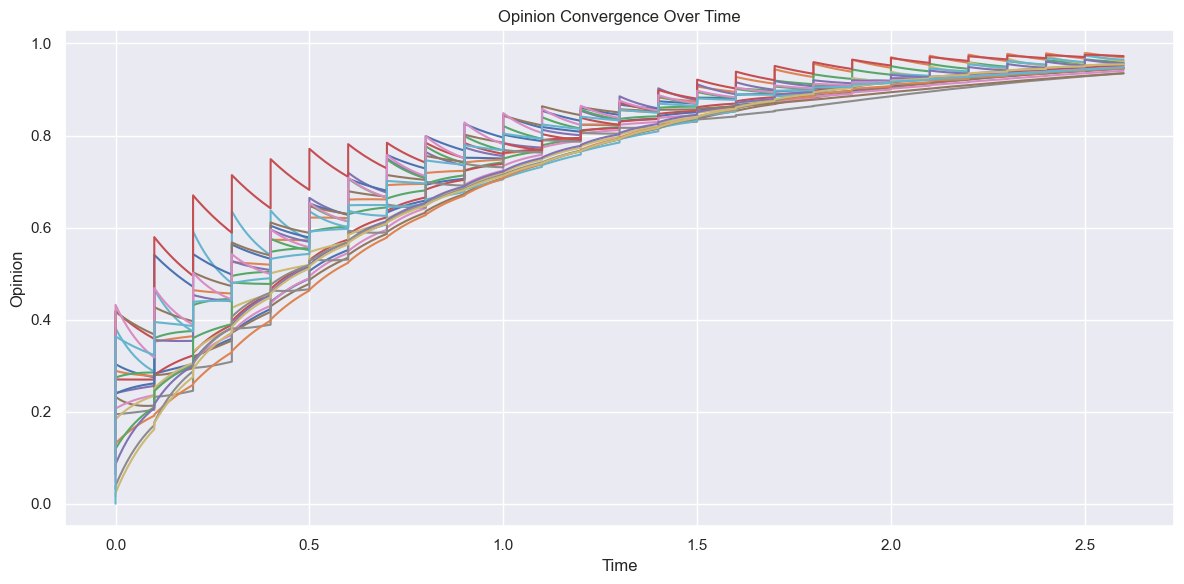

In [6]:
# best performing
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0"

# last run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May02-101004_configs\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\1" # excellent run


exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May29-012929_configs\0000_optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.5__agent_params.args_.target_model_update_freq_1000\1" 


agent = instantiate_agent(exp_subdir)

max_steps = 30
states, times, rewards, actions = run_policy_agent(agent, max_steps=max_steps)

interpolated_states, interpolated_times = interpolate_opinion_trajectory(
    env=agent.validation_env,
    opinions_over_time=states,
    actions=actions,
    n_substeps=10,  # increase for smoother curves
)

# Plot the smooth trajectory
plot_opinions_over_time(interpolated_states, interpolated_times)



In [7]:
len(actions)

26

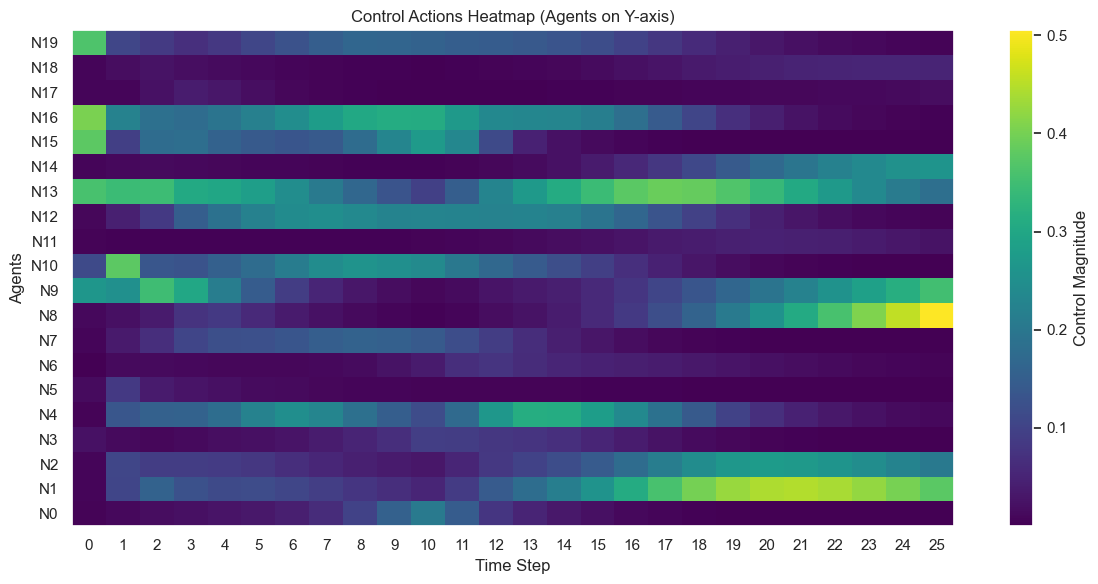

In [8]:
plot_action_heatmap(actions)


In [9]:
gamma = 0.99
total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

-7.323947319824967

In [10]:
sum(rewards)

-7.803334209718489

In [11]:
actions

array([[4.64189891e-03, 6.26258133e-03, 7.82038830e-03, 2.30925065e-02,
        4.73518809e-03, 1.41541194e-02, 1.74875022e-03, 6.38173101e-03,
        1.15471389e-02, 2.65275121e-01, 1.13057554e-01, 5.38826687e-03,
        9.73100681e-03, 3.58165652e-01, 7.23792473e-03, 3.77840072e-01,
        4.03889060e-01, 7.67297996e-03, 7.74706295e-03, 3.63610923e-01],
       [1.06642693e-02, 1.03509486e-01, 1.04839928e-01, 1.34188831e-02,
        1.34132147e-01, 8.47283527e-02, 1.26474015e-02, 3.54613103e-02,
        2.13321093e-02, 2.51563787e-01, 3.78121406e-01, 3.21361306e-03,
        4.43884619e-02, 3.44444752e-01, 1.06776953e-02, 9.39641893e-02,
        2.23320901e-01, 7.36494549e-03, 1.61662996e-02, 1.06040008e-01],
       [1.72546823e-02, 1.57425150e-01, 9.02682692e-02, 8.33890121e-03,
        1.54379800e-01, 3.55146863e-02, 1.23249199e-02, 6.58949167e-02,
        3.56263444e-02, 3.47506434e-01, 1.34165049e-01, 3.24455579e-03,
        8.43973383e-02, 3.46395880e-01, 1.31362099e-02, 1.7616